In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
# 1. backtest.py

#!/usr/bin/python
# -*- coding: utf-8 -*-


from __future__ import print_function

import datetime
import pprint
try:
    import Queue as queue
except ImportError:
    import queue
import time

print("Executing backtest.py")
class Backtest(object):
    """
    Enscapsulates the settings and components for carrying out
    an event-driven backtest.
    """

    def __init__(
        self, csv_dir, symbol_list, initial_capital,
        heartbeat, start_date, data_handler, 
        execution_handler, portfolio, strategy
    ):
        """
        Initialises the backtest.
        Parameters:
        csv_dir - The hard root to the CSV data directory.
        symbol_list - The list of symbol strings.
        intial_capital - The starting capital for the portfolio.
        heartbeat - Backtest "heartbeat" in seconds
        start_date - The start datetime of the strategy.
        data_handler - (Class) Handles the market data feed.
        execution_handler - (Class) Handles the orders/fills for trades.
        portfolio - (Class) Keeps track of portfolio current and prior positions.
        strategy - (Class) Generates signals based on market data.
        """
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list
        self.initial_capital = initial_capital
        self.heartbeat = heartbeat
        self.start_date = start_date

        self.data_handler_cls = data_handler
        self.execution_handler_cls = execution_handler
        self.portfolio_cls = portfolio
        self.strategy_cls = strategy

        # Added by Brad on 20191006
        # self.plots_cls = plots

        self.events = queue.Queue()
        
        self.signals = 0
        self.orders = 0
        self.fills = 0
        self.num_strats = 1
       
        self._generate_trading_instances()

    def _generate_trading_instances(self):
        # function1: call0 classes of 1)DataHandler, 2)strategy, 3)portfolion, 4)ExecutionHandler
        """
        Generates the trading instance objects from 
        their class types.
        """
        print(
            "Creating DataHandler, Strategy, Portfolio and ExecutionHandler"
        )
        self.data_handler = self.data_handler_cls(self.events, self.csv_dir, self.symbol_list)
        self.strategy = self.strategy_cls(self.data_handler, self.events)
        self.portfolio = self.portfolio_cls(self.data_handler, self.events, self.start_date, 
                                            self.initial_capital)
        self.execution_handler = self.execution_handler_cls(self.events)

    def _run_backtest(self): # 
        # function1: update market bars
        # function2: identify the current event, including 1)market, 2)signal, 3)order, 4)
        """
        Executes the backtest.
        """
        print("Running Backtest...")
        i = 0
        while True:
            i += 1
            # print(i)

            # Update the market bars
            if self.data_handler.continue_backtest == True:
                self.data_handler.update_bars()
            else:
                break

            # Handle the events
            while True:
                try:
                    event = self.events.get(False)
                except queue.Empty:
                    break
                else:
                    if event is not None:
                        if event.type == 'MARKET':
                            self.strategy.calculate_signals(event)
                            self.portfolio.update_timeindex(event)

                        elif event.type == 'SIGNAL':
                            self.signals += 1                            
                            self.portfolio.update_signal(event)

                        elif event.type == 'ORDER':
                            self.orders += 1
                            self.execution_handler.execute_order(event)

                        elif event.type == 'FILL':
                            self.fills += 1
                            self.portfolio.update_fill(event)

            time.sleep(self.heartbeat)

	# OG version
    # def _output_performance(self):
    #     """
    #     Outputs the strategy performance from the backtest.
    #     """
    #     self.portfolio.create_equity_curve_dataframe()
        
    #     print("Creating summary stats...")
    #     stats = self.portfolio.output_summary_stats()
        
    #     print("Creating equity curve...")
    #     print(self.portfolio.equity_curve.tail(10))
    #     pprint.pprint(stats)

    #     print("Signals: %s" % self.signals)
    #     print("Orders: %s" % self.orders)
    #     print("Fills: %s" % self.fills)


    def _output_performance(self):
        """
        Outputs the strategy performance from the backtest.
        """
        self.portfolio.create_equity_curve_dataframe()
        
        print("Creating summary stats...")
        stats = self.portfolio.output_summary_stats()
        
        print("Creating equity curve...")
        print(self.portfolio.equity_curve.tail(10))
        pprint.pprint(stats)

        print("Signals: %s" % self.signals)
        print("Orders: %s" % self.orders)
        print("Fills: %s" % self.fills)

    def simulate_trading(self):
        # function 1: call 1)_run _backtest, 2__output_formance
        """
        Simulates the backtest and outputs portfolio performance.
        """
        self._run_backtest()
        self._output_performance()

Executing backtest.py


In [3]:
# 2. event.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

print("Executing event.py")
class Event(object):
    """
    Event is base class providing an interface for all subsequent 
    (inherited) events, that will trigger further events in the 
    trading infrastructure.   
    """
    pass


class MarketEvent(Event):
    """
    Handles the event of receiving a new market update with 
    corresponding bars.
    """

    def __init__(self):
        """
        Initialises the MarketEvent.
        """
        self.type = 'MARKET'


class SignalEvent(Event):
    """
    Handles the event of sending a Signal from a Strategy object.
    This is received by a Portfolio object and acted upon.
    """
    
    def __init__(self, strategy_id, symbol, datetime, signal_type, strength):
        """
        Initialises the SignalEvent.
        Parameters:
        strategy_id - The unique ID of the strategy sending the signal.
        symbol - The ticker symbol, e.g. 'GOOG'.
        datetime - The timestamp at which the signal was generated.
        signal_type - 'LONG' or 'SHORT'.
        strength - An adjustment factor "suggestion" used to scale 
            quantity at the portfolio level. Useful for pairs strategies.
        """
        self.strategy_id = strategy_id
        self.type = 'SIGNAL'
        self.symbol = symbol
        self.datetime = datetime
        self.signal_type = signal_type
        self.strength = strength


class OrderEvent(Event):
    """
    Handles the event of sending an Order to an execution system.
    The order contains a symbol (e.g. GOOG), a type (market or limit),
    quantity and a direction.
    """

    def __init__(self, symbol, order_type, quantity, direction):
        """
        Initialises the order type, setting whether it is
        a Market order ('MKT') or Limit order ('LMT'), has
        a quantity (integral) and its direction ('BUY' or
        'SELL').
        TODO: Must handle error checking here to obtain 
        rational orders (i.e. no negative quantities etc).
        Parameters:
        symbol - The instrument to trade.
        order_type - 'MKT' or 'LMT' for Market or Limit.
        quantity - Non-negative integer for quantity.
        direction - 'BUY' or 'SELL' for long or short.
        """
        self.type = 'ORDER'
        self.symbol = symbol
        self.order_type = order_type
        self.quantity = quantity
        self.direction = direction

    def print_order(self):
        """
        Outputs the values within the Order.
        """
        print(
            "Order: Symbol=%s, Type=%s, Quantity=%s, Direction=%s" % 
            (self.symbol, self.order_type, self.quantity, self.direction)
        )


class FillEvent(Event):
    """
    Encapsulates the notion of a Filled Order, as returned
    from a brokerage. Stores the quantity of an instrument
    actually filled and at what price. In addition, stores
    the commission of the trade from the brokerage.
    
    TODO: Currently does not support filling positions at
    different prices. This will be simulated by averaging
    the cost.
    """

    def __init__(self, timeindex, symbol, exchange, quantity, 
                 direction, fill_cost, commission=None):
        """
        Initialises the FillEvent object. Sets the symbol, exchange,
        quantity, direction, cost of fill and an optional 
        commission.
        If commission is not provided, the Fill object will
        calculate it based on the trade size and Interactive
        Brokers fees.
        Parameters:
        timeindex - The bar-resolution when the order was filled.
        symbol - The instrument which was filled.
        exchange - The exchange where the order was filled.
        quantity - The filled quantity.
        direction - The direction of fill ('BUY' or 'SELL')
        fill_cost - The holdings value in dollars.
        commission - An optional commission sent from IB.
        """
        self.type = 'FILL'
        self.timeindex = timeindex
        self.symbol = symbol
        self.exchange = exchange
        self.quantity = quantity
        self.direction = direction
        self.fill_cost = fill_cost

        # Calculate commission
        if commission is None:
            self.commission = self.calculate_ib_commission()
        else:
            self.commission = commission

    def calculate_ib_commission(self):
        """
        Calculates the fees of trading based on an Interactive
        Brokers fee structure for API, in USD.
        This does not include exchange or ECN fees.
        Based on "US API Directed Orders":
        https://www.interactivebrokers.com/en/index.php?f=commission&p=stocks2
        """
#         full_cost = 1.3
#         if self.quantity <= 500:
#             full_cost = max(1.3, 0.013 * self.quantity)
#         else: # Greater than 500
#             full_cost = max(1.3, 0.008 * self.quantity)
        full_cost = 0
        return full_cost

Executing event.py


In [4]:
# 3. data.py
#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
import os, os.path

import numpy as np
import pandas as pd

# from event import MarketEvent

print("Executing data.py")
class DataHandler(object):
    """
    DataHandler is an abstract base class providing an interface for
    all subsequent (inherited) data handlers (both live and historic).
    The goal of a (derived) DataHandler object is to output a generated
    set of bars (OHLCVI) for each symbol requested. 
    This will replicate how a live strategy would function as current
    market data would be sent "down the pipe". Thus a historic and live
    system will be treated identically by the rest of the backtesting suite.
    """

    __metaclass__ = ABCMeta

    @abstractmethod
    def get_latest_bar(self, symbol):
        """
        Returns the last bar updated.
        """
        raise NotImplementedError("Should implement get_latest_bar()")

    @abstractmethod
    def get_latest_bars(self, symbol, N=1):
        """
        Returns the last N bars updated.
        """
        raise NotImplementedError("Should implement get_latest_bars()")

    @abstractmethod
    def get_latest_bar_datetime(self, symbol):
        """
        Returns a Python datetime object for the last bar.
        """
        raise NotImplementedError("Should implement get_latest_bar_datetime()")

    @abstractmethod
    def get_latest_bar_value(self, symbol, val_type):
        """
        Returns one of the Open, High, Low, Close, Volume or OI
        from the last bar.
        """
        raise NotImplementedError("Should implement get_latest_bar_value()")

    @abstractmethod
    def get_latest_bars_values(self, symbol, val_type, N=1):
        """
        Returns the last N bar values from the 
        latest_symbol list, or N-k if less available.
        """
        raise NotImplementedError("Should implement get_latest_bars_values()")

    @abstractmethod
    def update_bars(self):
        """
        Pushes the latest bars to the bars_queue for each symbol
        in a tuple OHLCVI format: (datetime, open, high, low, 
        close, volume, open interest).
        """
        raise NotImplementedError("Should implement update_bars()")


class HistoricCSVDataHandler(DataHandler):
    """
    HistoricCSVDataHandler is designed to read CSV files for
    each requested symbol from disk and provide an interface
    to obtain the "latest" bar in a manner identical to a live
    trading interface. 
    """

    def __init__(self, events, csv_dir, symbol_list):
        """
        Initialises the historic data handler by requesting
        the location of the CSV files and a list of symbols.
        It will be assumed that all files are of the form
        'symbol.csv', where symbol is a string in the list.
        Parameters:
        events - The Event Queue.
        csv_dir - Absolute directory path to the CSV files.
        symbol_list - A list of symbol strings.
        """
        self.events = events
        self.csv_dir = csv_dir
        self.symbol_list = symbol_list

        self.symbol_data = {}
        self.latest_symbol_data = {}
        self.continue_backtest = True       
        self.bar_index = 0

        self._open_convert_csv_files()

    def _open_convert_csv_files(self):
        """
        Opens the CSV files from the data directory, converting
        them into pandas DataFrames within a symbol dictionary.
        For this handler it will be assumed that the data is
        taken from Yahoo. Thus its format will be respected.
        """
        comb_index = None

        for s in self.symbol_list:
            # Load the CSV file with no header information, indexed on date
            self.symbol_data[s] = pd.io.parsers.read_csv(
                os.path.join(self.csv_dir, '%s.csv' % s),
                header=0, index_col=0, parse_dates=True,
                names=['Date', 'Open', 'High','Low', 'Close', 'Adj Close', 'Volume','Ticker'
                ]
            )
            # ).sort_values('date')

            # Combine the index to pad forward values
            if comb_index is None:
                comb_index = self.symbol_data[s].index
            else:
                comb_index.union(self.symbol_data[s].index)

            # Set the latest symbol_data to None
            self.latest_symbol_data[s] = []

        # Reindex the dataframes
        for s in self.symbol_list:
            self.symbol_data[s] = self.symbol_data[s].\
                reindex(index=comb_index, method='pad').iterrows()

    def _get_new_bar(self, symbol):
        """
        Returns the latest bar from the data feed.
        """
        for b in self.symbol_data[symbol]:
            yield b

    def get_latest_bar(self, symbol):
        """
        Returns the last bar from the latest_symbol list.
        """
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-1]

    def get_latest_bars(self, symbol, N=1):
        """
        Returns the last N bars from the latest_symbol list,
        or N-k if less available.
        """
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-N:]

    def get_latest_bar_datetime(self, symbol):
        """
        Returns a Python datetime object for the last bar.
        """
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return bars_list[-1][0]

    def get_latest_bar_value(self, symbol, val_type):
        """
        Returns one of the Open, High, Low, Close, Volume or OI
        values from the pandas Bar series object.
        """
        try:
            bars_list = self.latest_symbol_data[symbol]
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return getattr(bars_list[-1][1], val_type)

    def get_latest_bars_values(self, symbol, val_type, N=1):
        """
        Returns the last N bar values from the 
        latest_symbol list, or N-k if less available.
        """
        try:
            bars_list = self.get_latest_bars(symbol, N)
        except KeyError:
            print("That symbol is not available in the historical data set.")
            raise
        else:
            return np.array([getattr(b[1], val_type) for b in bars_list])

    def update_bars(self):
        """
        Pushes the latest bar to the latest_symbol_data structure
        for all symbols in the symbol list.
        """
        for s in self.symbol_list:
            try:
                bar = next(self._get_new_bar(s))
            except StopIteration:
                self.continue_backtest = False
            else:
                if bar is not None:
                    self.latest_symbol_data[s].append(bar)
        self.events.put(MarketEvent())

Executing data.py


In [5]:
# 4. execution.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
try:
    import Queue as queue
except ImportError:
    import queue

# from event import FillEvent, OrderEvent

print("Executing execution.py")
class ExecutionHandler(object):
    """
    The ExecutionHandler abstract class handles the interaction
    between a set of order objects generated by a Portfolio and
    the ultimate set of Fill objects that actually occur in the
    market. 
    The handlers can be used to subclass simulated brokerages
    or live brokerages, with identical interfaces. This allows
    strategies to be backtested in a very similar manner to the
    live trading engine.
    """

    __metaclass__ = ABCMeta

    @abstractmethod
    def execute_order(self, event):
        """
        Takes an Order event and executes it, producing
        a Fill event that gets placed onto the Events queue.
        Parameters:
        event - Contains an Event object with order information.
        """
        raise NotImplementedError("Should implement execute_order()")


class SimulatedExecutionHandler(ExecutionHandler):
    """
    The simulated execution handler simply converts all order
    objects into their equivalent fill objects automatically
    without latency, slippage or fill-ratio issues.
    This allows a straightforward "first go" test of any strategy,
    before implementation with a more sophisticated execution
    handler.
    """
    
    def __init__(self, events):
        """
        Initialises the handler, setting the event queues
        up internally.
        Parameters:
        events - The Queue of Event objects.
        """
        self.events = events

    def execute_order(self, event):
        """
        Simply converts Order objects into Fill objects naively,
        i.e. without any latency, slippage or fill ratio problems.
        Parameters:
        event - Contains an Event object with order information.
        """
        if event.type == 'ORDER':
            fill_event = FillEvent(
                datetime.datetime.utcnow(), event.symbol,
                'ARCA', event.quantity, event.direction, None
            )
            self.events.put(fill_event)

Executing execution.py


In [6]:
# 5. strategy.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

from abc import ABCMeta, abstractmethod
import datetime
try:
    import Queue as queue
except ImportError:
    import queue

import numpy as np
import pandas as pd

# from event import SignalEvent

print("Executing strategy.py")
class Strategy(object):
    """
    Strategy is an abstract base class providing an interface for
    all subsequent (inherited) strategy handling objects.
    The goal of a (derived) Strategy object is to generate Signal
    objects for particular symbols based on the inputs of Bars 
    (OHLCV) generated by a DataHandler object.
    This is designed to work both with historic and live data as
    the Strategy object is agnostic to where the data came from,
    since it obtains the bar tuples from a queue object.
    """

    __metaclass__ = ABCMeta

    @abstractmethod
    def calculate_signals(self):
        """
        Provides the mechanisms to calculate the list of signals.
        """
        raise NotImplementedError("Should implement calculate_signals()")

Executing strategy.py


In [7]:
# 6. portfolio.py

#!/usr/bin/python
# -*- coding: utf-8 -*-


from __future__ import print_function

import datetime
from math import floor
try:
    import Queue as queue
except ImportError:
    import queue

import numpy as np
import pandas as pd

# from event import FillEvent, OrderEvent
# from performance import create_sharpe_ratio, create_drawdowns


print("Executing portfolio.py")
class Portfolio(object):
    """
    The Portfolio class handles the positions and market
    value of all instruments at a resolution of a "bar",
    i.e. secondly, minutely, 5-min, 30-min, 60 min or EOD.
    The positions DataFrame stores a time-index of the 
    quantity of positions held. 
    The holdings DataFrame stores the cash and total market
    holdings value of each symbol for a particular 
    time-index, as well as the percentage change in 
    portfolio total across bars.
    """

    def __init__(self, bars, events, start_date, initial_capital=100000.0):
        """
        Initialises the portfolio with bars and an event queue. 
        Also includes a starting datetime index and initial capital 
        (USD unless otherwise stated).
        Parameters:
        bars - The DataHandler object with current market data.
        events - The Event Queue object.
        start_date - The start date (bar) of the portfolio.
        initial_capital - The starting capital in USD.
        """
        self.bars = bars
        self.events = events
        self.symbol_list = self.bars.symbol_list
        self.start_date = start_date
        self.initial_capital = initial_capital
        
        self.all_positions = self.construct_all_positions()
        self.current_positions = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        self.all_holdings = self.construct_all_holdings()
        self.current_holdings = self.construct_current_holdings()
        
        # Brad's add on 20191117
#         fill.direction = "None"
#         self.fill_cost = self.update_holdings_from_fill(self, fill)
        
        # =============brad's added on 20191117:===============
        self.len_symbol_list = len(symbol_list)
        print("Number of assets in the portfolio： ",self.len_symbol_list)
        print("Position Value for each asset: ", self.initial_capital/self.len_symbol_list)

        
    def construct_all_positions(self):
        """
        Constructs the positions list using the start_date
        to determine when the time index will begin.
        """
        d = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        d['datetime'] = self.start_date
        return [d]

    def construct_all_holdings(self):
        """
        Constructs the holdings list using the start_date
        to determine when the time index will begin.
        """
        d = dict( (k,v) for k, v in [(s, 0.0) for s in self.symbol_list] )
        d['datetime'] = self.start_date
        d['cash'] = self.initial_capital
        d['commission'] = 0.0
        d['total'] = self.initial_capital
        return [d]

    def construct_current_holdings(self):
        """
        This constructs the dictionary which will hold the instantaneous
        value of the portfolio across all symbols.
        """
        d = dict( (k,v) for k, v in [(s, 0.0) for s in self.symbol_list] )
        d['cash'] = self.initial_capital
        d['commission'] = 0.0
        d['total'] = self.initial_capital
        return d

    def update_timeindex(self, event):
        """
        Adds a new record to the positions matrix for the current 
        market data bar. This reflects the PREVIOUS bar, i.e. all
        current market data at this stage is known (OHLCV).
        Makes use of a MarketEvent from the events queue.
        """
        latest_datetime = self.bars.get_latest_bar_datetime(self.symbol_list[0])

        # Update positions
        # ================
        dp = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        dp['datetime'] = latest_datetime

        for s in self.symbol_list:
            dp[s] = self.current_positions[s]

        # Append the current positions
        self.all_positions.append(dp)

        # Update holdings
        # ===============
        dh = dict( (k,v) for k, v in [(s, 0) for s in self.symbol_list] )
        dh['datetime'] = latest_datetime
        dh['cash'] = self.current_holdings['cash']
        dh['commission'] = self.current_holdings['commission']
        dh['total'] = self.current_holdings['cash']

        for s in self.symbol_list:
            # Approximation to the real value
            market_value = self.current_positions[s] * \
                self.bars.get_latest_bar_value(s, "Adj Close")
            dh[s] = market_value
            dh['total'] += market_value

        # Append the current holdings
        self.all_holdings.append(dh)

    # ======================
    # FILL/POSITION HANDLING
    # ======================

    def update_positions_from_fill(self, fill):
        """
        Takes a Fill object and updates the position matrix to
        reflect the new position.
        Parameters:
        fill - The Fill object to update the positions with.
        """
        # Check whether the fill is a buy or sell
        fill_dir = 0
        if fill.direction == 'BUY':
            fill_dir = 1
        if fill.direction == 'SELL':
            fill_dir = -1

        # Update positions list with new quantities
        self.current_positions[fill.symbol] += fill_dir*fill.quantity

    def update_holdings_from_fill(self, fill):
        """
        Takes a Fill object and updates the holdings matrix to
        reflect the holdings value.
        Parameters:
        fill - The Fill object to update the holdings with.
        """
        # Check whether the fill is a buy or sell
        fill_dir = 0
        if fill.direction == 'BUY':
            fill_dir = 1
        if fill.direction == 'SELL':
            fill_dir = -1

        # Update holdings list with new quantities
        fill_cost = self.bars.get_latest_bar_value(
            fill.symbol, "Adj Close"
        )
        cost = fill_dir * fill_cost * fill.quantity
        self.current_holdings[fill.symbol] += cost
        self.current_holdings['commission'] += fill.commission
        self.current_holdings['cash'] -= (cost + fill.commission)
        self.current_holdings['total'] -= (cost + fill.commission)
        # Brad's add on 20191117
        return fill_cost

    def update_fill(self, event):
        """
        Updates the portfolio current positions and holdings 
        from a FillEvent.
        """
        if event.type == 'FILL':
            self.update_positions_from_fill(event)
            self.update_holdings_from_fill(event)

    def generate_naive_order(self, signal):
        """
        Simply files an Order object as a constant quantity
        sizing of the signal object, without risk management or
        position sizing considerations.
        Parameters:
        signal - The tuple containing Signal information.
        """
        order = None

        symbol = signal.symbol
        direction = signal.signal_type
        strength = signal.strength
        # ================ Brad's change on 20191117 =================
#         mkt_quantity = 100
        symbol_value = self.bars.get_latest_bar_value(symbol, "Adj Close")
        mkt_quantity = int(self.initial_capital/self.len_symbol_list/symbol_value)
        print("Asset: ", symbol, "symbol_value: ",symbol_value,  "mkt_quantity: ", mkt_quantity)
        cur_quantity = self.current_positions[symbol]
        order_type = 'MKT'

        if direction == 'LONG' and cur_quantity == 0:
            order = OrderEvent(symbol, order_type, mkt_quantity, 'BUY')
        if direction == 'SHORT' and cur_quantity == 0:
            order = OrderEvent(symbol, order_type, mkt_quantity, 'SELL')   
    
        if direction == 'EXIT' and cur_quantity > 0:
            order = OrderEvent(symbol, order_type, abs(cur_quantity), 'SELL')
        if direction == 'EXIT' and cur_quantity < 0:
            order = OrderEvent(symbol, order_type, abs(cur_quantity), 'BUY')
        return order

    def update_signal(self, event):
        """
        Acts on a SignalEvent to generate new orders 
        based on the portfolio logic.
        """
        if event.type == 'SIGNAL':
            order_event = self.generate_naive_order(event)
            self.events.put(order_event)

    # ========================
    # POST-BACKTEST STATISTICS
    # ========================

    def create_equity_curve_dataframe(self):
        """
        Creates a pandas DataFrame from the all_holdings
        list of dictionaries.
        """
        curve = pd.DataFrame(self.all_holdings)
        curve.set_index('datetime', inplace=True)
        curve['returns'] = curve['total'].pct_change()
        curve['equity_curve'] = (1.0+curve['returns']).cumprod()
        self.equity_curve = curve

    def output_summary_stats(self):
        """
        Creates a list of summary statistics for the portfolio.
        """
        total_return = self.equity_curve['equity_curve'][-1]
        returns = self.equity_curve['returns']
        pnl = self.equity_curve['equity_curve']

        sharpe_ratio = create_sharpe_ratio(returns, periods=252*60*6.5)
        drawdown, max_dd, dd_duration = create_drawdowns(pnl)
        self.equity_curve['drawdown'] = drawdown

        stats = [("Total Return", "%0.2f%%" % ((total_return - 1.0) * 100.0)),
                 ("Sharpe Ratio", "%0.2f" % sharpe_ratio),
                 ("Max Drawdown", "%0.2f%%" % (max_dd * 100.0)),
                 ("Drawdown Duration", "%d" % dd_duration)]

        self.equity_curve.to_csv('equity.csv')
        return stats

    # Added by Brad on 20191007:
    def draw_summary_plots(self):
        print("Testing draw_summary_plots")
        self.equity_curve['equity_curve'].plot(figsize = (18,6))

Executing portfolio.py


In [8]:
# 7. performance.py

#!/usr/bin/python
# -*- coding: utf-8 -*-

from __future__ import print_function

import numpy as np
import pandas as pd

print("Executing performance.py")
def create_sharpe_ratio(returns, periods=252):
    """
    Create the Sharpe ratio for the strategy, based on a 
    benchmark of zero (i.e. no risk-free rate information).
    Parameters:
    returns - A pandas Series representing period percentage returns.
    periods - Daily (252), Hourly (252*6.5), Minutely(252*6.5*60) etc.
    """
    return np.sqrt(periods) * (np.mean(returns)) / np.std(returns)


def create_drawdowns(pnl):
    """
    Calculate the largest peak-to-trough drawdown of the PnL curve
    as well as the duration of the drawdown. Requires that the 
    pnl_returns is a pandas Series.
    Parameters:
    pnl - A pandas Series representing period percentage returns.
    Returns:
    drawdown, duration - Highest peak-to-trough drawdown and duration.
    """

    # Calculate the cumulative returns curve 
    # and set up the High Water Mark
    hwm = [0]

    # Create the drawdown and duration series
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)

    # Loop over the index range
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t]= (hwm[t]-pnl[t])
        duration[t]= (0 if drawdown[t] == 0 else duration[t-1]+1)
    return drawdown, drawdown.max(), duration.max()

Executing performance.py


In [21]:
# mac.py
print("Executing mac.py")
class MovingAverageCrossStrategy(Strategy):
    """
    Carries out a basic Moving Average Crossover strategy with a
    short/long simple weighted moving average. Default short/long
    windows are 12/26 periods respectively.
    """

    def __init__(self, bars, events, short_window=12, long_window=26):
        """
        Initialises the buy and hold strategy.

        Parameters:
        bars - The DataHandler object that provides bar information
        events - The Event Queue object.
        short_window - The short moving average lookback.
        long_window - The long moving average lookback.
        """
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.    

        Parameters
        event - A MarketEvent object. 
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(symbol, "Adj Close", N=self.long_window)

                if bars is not None and bars != []:
                    short_sma = np.mean(bars[-self.short_window:])
                    long_sma = np.mean(bars[-self.long_window:])

                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 1

                    if short_sma > long_sma and self.bought[symbol] == "OUT":
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif short_sma < long_sma and self.bought[symbol] == "LONG":
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'


class movingAverageConvergenceDivergence(Strategy):
    def __init__(self, bars, events, short_window=12, long_window=26):
        self.bars = bars
        self.symbol_list = self.bars.symbol_list
        self.events = events
        self.short_window = short_window
        self.long_window = long_window

        # Set to True if a symbol is in the market
        self.bought = self._calculate_initial_bought()

    def _calculate_initial_bought(self):
        """
        Adds keys to the bought dictionary for all symbols
        and sets them to 'OUT'.
        """
        bought = {}
        for s in self.symbol_list:
            bought[s] = 'OUT'
        return bought

    def calculate_signals(self, event):
        """
        Generates a new set of signals based on the MAC
        SMA with the short window crossing the long window
        meaning a long entry and vice versa for a short entry.
        Parameters
        event - A MarketEvent object.
        """
        if event.type == 'MARKET':
            for symbol in self.symbol_list:
                bars = self.bars.get_latest_bars_values(symbol, "Close", N=self.long_window)

                if bars is not None and bars != []:
#                     print('-------', bars)
                    exp1 = pd.Series(bars[-self.short_window:]).ewm(span=12, adjust=False).mean().iloc[-1]
                    exp2 = pd.Series(bars[-self.long_window:]).ewm(span=26, adjust=False).mean().iloc[-1]
                    macd = exp1 - exp2
                    exp3 = pd.Series(bars[-self.long_window:]).ewm(span=9, adjust=False).mean().iloc[-1]
                    dt = self.bars.get_latest_bar_datetime(symbol)
                    sig_dir = ""
                    strength = 1.0
                    strategy_id = 2

                    if macd < exp3 and self.bought[symbol] == "OUT":
                        sig_dir = 'LONG'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'LONG'

                    elif macd > exp3 and self.bought[symbol] == "LONG":
                        sig_dir = 'EXIT'
                        signal = SignalEvent(strategy_id, symbol, dt, sig_dir, strength)
                        self.events.put(signal)
                        self.bought[symbol] = 'OUT'
                        
                        
                        
                        
if __name__ == "__main__":
    # csv_dir = REPLACE_WITH_YOUR_CSV_DIR_HERE
    csv_dir = "/Users/miaoyuesun/Code_Workspace/brad_public_workspace_mac/data/US_database"
#     symbol_list = ["IYM","IYZ","FCL","FCD","IYE","IYG","IYH","IYJ","IYR","IYW","IDU"]
#     symbol_list = ['TSLA','AMZN','AAPL']
#     symbol_list = ['SPY']
#     symbol_list = ["VTI","TLT","IEF","GLD","DBC"]
#     symbol_list = ['jd000d']
    symbol_list = ['QQQ', 'SPY', 'TSLA',  'YELP']
    initial_capital = 100000.0
    start_date = datetime.datetime(2010,4,1,0,0,0)
    start_date_str = str(start_date)
    heartbeat = 0.0

    backtest = Backtest(csv_dir, 
                        symbol_list, 
                        initial_capital, 
                        heartbeat,
                        start_date,
                        HistoricCSVDataHandler, 
                        SimulatedExecutionHandler, 
                        Portfolio, 
                        MovingAverageCrossStrategy,
#                         movingAverageConvergenceDivergence
                       )
    
    backtest.simulate_trading()

Executing mac.py
Creating DataHandler, Strategy, Portfolio and ExecutionHandler
Number of assets in the portfolio：  4
Position Value for each asset:  25000.0
Running Backtest...
Asset:  QQQ symbol_value:  45.39594650268555 mkt_quantity:  550
Asset:  SPY symbol_value:  88.08079528808594 mkt_quantity:  283
Asset:  SPY symbol_value:  89.85780334472656 mkt_quantity:  278
Asset:  SPY symbol_value:  89.3868179321289 mkt_quantity:  279
Asset:  SPY symbol_value:  87.95235443115234 mkt_quantity:  284
Asset:  SPY symbol_value:  92.38421630859376 mkt_quantity:  270
Asset:  QQQ symbol_value:  46.82140350341797 mkt_quantity:  533
Asset:  QQQ symbol_value:  47.53414916992188 mkt_quantity:  525
Asset:  QQQ symbol_value:  48.65808486938477 mkt_quantity:  513


/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:52: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
/Users/miaoyuesun/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py:52: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Asset:  QQQ symbol_value:  47.6917724609375 mkt_quantity:  524
Asset:  QQQ symbol_value:  43.7237434387207 mkt_quantity:  571
Asset:  SPY symbol_value:  88.38053894042969 mkt_quantity:  282
Asset:  QQQ symbol_value:  48.30171203613281 mkt_quantity:  517
Asset:  SPY symbol_value:  92.5127410888672 mkt_quantity:  270
Asset:  SPY symbol_value:  91.22430419921876 mkt_quantity:  274
Asset:  QQQ symbol_value:  49.50787734985352 mkt_quantity:  504
Asset:  QQQ symbol_value:  52.8248519897461 mkt_quantity:  473
Asset:  SPY symbol_value:  93.9515609741211 mkt_quantity:  266
Asset:  SPY symbol_value:  91.02027130126952 mkt_quantity:  274
Asset:  QQQ symbol_value:  52.81800842285156 mkt_quantity:  473
Asset:  QQQ symbol_value:  53.78431701660156 mkt_quantity:  464
Asset:  QQQ symbol_value:  53.86655044555664 mkt_quantity:  464
Asset:  QQQ symbol_value:  57.37540817260742 mkt_quantity:  435
Asset:  SPY symbol_value:  92.75178527832031 mkt_quantity:  269
Asset:  SPY symbol_value:  101.54991912841795

Asset:  SPY symbol_value:  99.58769989013672 mkt_quantity:  251
Asset:  QQQ symbol_value:  36.96061325073242 mkt_quantity:  676
Asset:  SPY symbol_value:  95.92431640625 mkt_quantity:  260
Asset:  SPY symbol_value:  97.28729248046876 mkt_quantity:  256
Asset:  SPY symbol_value:  94.62301635742188 mkt_quantity:  264
Asset:  SPY symbol_value:  97.7758560180664 mkt_quantity:  255
Asset:  QQQ symbol_value:  32.7484130859375 mkt_quantity:  763
Asset:  QQQ symbol_value:  39.10286712646485 mkt_quantity:  639
Asset:  QQQ symbol_value:  40.40481948852539 mkt_quantity:  618
Asset:  QQQ symbol_value:  39.37932586669922 mkt_quantity:  634
Asset:  QQQ symbol_value:  39.86978530883789 mkt_quantity:  627
Asset:  SPY symbol_value:  106.9181900024414 mkt_quantity:  233
Asset:  QQQ symbol_value:  38.21113967895508 mkt_quantity:  654
Asset:  QQQ symbol_value:  38.83304977416992 mkt_quantity:  643
Asset:  SPY symbol_value:  109.7806625366211 mkt_quantity:  227
Asset:  SPY symbol_value:  117.4993667602539 

Asset:  TSLA symbol_value:  29.11000061035156 mkt_quantity:  858
Asset:  YELP symbol_value:  18.190000534057614 mkt_quantity:  1374
Asset:  TSLA symbol_value:  28.54999923706055 mkt_quantity:  875
Asset:  YELP symbol_value:  26.20000076293945 mkt_quantity:  954
Asset:  TSLA symbol_value:  31.04999923706055 mkt_quantity:  805
Asset:  QQQ symbol_value:  63.279502868652344 mkt_quantity:  395
Asset:  TSLA symbol_value:  29.25 mkt_quantity:  854
Asset:  SPY symbol_value:  124.63009643554688 mkt_quantity:  200
Asset:  YELP symbol_value:  24.61000061035156 mkt_quantity:  1015
Asset:  TSLA symbol_value:  31.540000915527344 mkt_quantity:  792
Asset:  QQQ symbol_value:  60.7983283996582 mkt_quantity:  411
Asset:  SPY symbol_value:  122.7957763671875 mkt_quantity:  203
Asset:  YELP symbol_value:  18.09000015258789 mkt_quantity:  1381
Asset:  YELP symbol_value:  18.440000534057614 mkt_quantity:  1355
Asset:  TSLA symbol_value:  34.34000015258789 mkt_quantity:  728
Asset:  YELP symbol_value:  21.07

Asset:  YELP symbol_value:  21.200000762939453 mkt_quantity:  1179
Asset:  YELP symbol_value:  18.96999931335449 mkt_quantity:  1317
Asset:  YELP symbol_value:  20.780000686645508 mkt_quantity:  1203
Asset:  QQQ symbol_value:  103.39578247070312 mkt_quantity:  241
Asset:  TSLA symbol_value:  222.55999755859366 mkt_quantity:  112
Asset:  SPY symbol_value:  194.74114990234366 mkt_quantity:  128
Asset:  QQQ symbol_value:  106.69957733154295 mkt_quantity:  234
Asset:  SPY symbol_value:  196.4414825439453 mkt_quantity:  127
Asset:  TSLA symbol_value:  218.9900054931641 mkt_quantity:  114
Asset:  QQQ symbol_value:  104.17633819580078 mkt_quantity:  239
Asset:  TSLA symbol_value:  196.3999938964844 mkt_quantity:  127
Asset:  SPY symbol_value:  190.86119079589844 mkt_quantity:  130
Asset:  QQQ symbol_value:  108.0426254272461 mkt_quantity:  231
Asset:  SPY symbol_value:  201.82981872558602 mkt_quantity:  123
Asset:  TSLA symbol_value:  221.52999877929688 mkt_quantity:  112
Asset:  TSLA symbol_

Asset:  TSLA symbol_value:  336.5899963378906 mkt_quantity:  74
Asset:  YELP symbol_value:  33.200000762939446 mkt_quantity:  753
Asset:  TSLA symbol_value:  378.989990234375 mkt_quantity:  65
Asset:  YELP symbol_value:  35.0 mkt_quantity:  714
Asset:  YELP symbol_value:  34.380001068115234 mkt_quantity:  727
Creating summary stats...
Creating equity curve...
                     QQQ           SPY          TSLA          YELP  \
datetime                                                             
2020-01-31  29058.899841  27141.000000  41600.000000  24654.419128   
2020-02-03  28618.199921  26838.050507  43789.850159  23347.800545   
2020-02-04  29304.599762  27229.810608  57392.401428  23919.000000   
2020-02-05  29927.300873  27578.409088  53511.900635  24547.320763   
2020-02-06  29742.699127  27714.530304  45494.798889      0.000000   
2020-02-07  29790.800476  27624.060608  47485.749207      0.000000   
2020-02-10  29697.200317  27492.090912  52000.000000      0.000000   
2020-02-

In [12]:
53.57/9

5.952222222222222

https://www.xuebuyuan.com/3244260.html


- VOX	Vanguard Telecommunication Services ETF
- ======================
- IYM	iShares Dow Jones U.S. Basic Materials Sector Index Fund
- IYZ	iShares Dow Jones U.S. Telecommunications Sector Index Fund
- FCL	Focus Morningstar Consumer Cyclical Index ETF
- FCD	Focus Morningstar Consumer Defensive Index ETF
- IYE	iShares Dow Jones U.S. Energy Sector Index Fund
- IYG	iShares Dow Jones U.S. Financial Services Index Fund
- IYH	iShares Dow Jones U.S. Healthcare Sector Index Fund
- IYJ	iShares Dow Jones U.S. Industrial Sector Index Fund
- IYR	iShares Dow Jones U.S. Real Estate Index Fund
- IYW	iShares Dow Jones U.S. Technology Sector Index Fund
- IDU	iShares Dow Jones U.S. Utilities Sector Index Fund

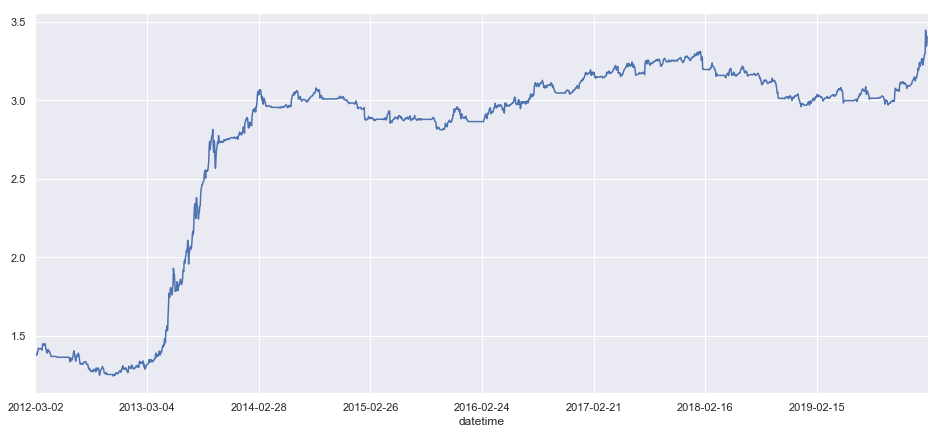

In [22]:
df_equity = pd.read_csv("equity.csv")
df_equity.drop_duplicates("datetime", inplace = True)
df_equity =df_equity[df_equity['datetime']>start_date_str]
df_equity.index = df_equity['datetime']
df_equity = df_equity[df_equity['total'].map(lambda x: str(x)!="nan")]
del df_equity['datetime']
df_equity['equity_curve'].plot(figsize = (16, 7))

In [19]:
df_equity

,QQQ,SPY,TSLA,YELP,cash,commission,total,returns,equity_curve,drawdown
datetime,,,,,,,,,,
2012-03-02,33104.812946,32930.575867,35605.840958,0.000000,25031.669769,0.0,126672.899540,0.266729,1.266729,0.000000
2012-03-05,32762.885742,32796.275330,35323.420479,21346.829767,33.809847,0.0,122263.221165,-0.034812,1.222632,0.044097
2012-03-06,32441.389103,32316.623230,34633.060638,20848.500000,33.809847,0.0,120273.382818,-0.016275,1.202734,0.063995
2012-03-07,32691.440163,32542.051086,34643.518883,20594.250000,33.809847,0.0,120505.069979,0.001926,1.205051,0.061678
2012-03-08,33043.567829,32865.813904,34591.219681,20340.000000,33.809847,0.0,120874.411261,0.003065,1.208744,0.057985
...,...,...,...,...,...,...,...,...,...,...
2020-01-28,121900.199661,91016.799316,594640.529785,36266.219845,33.809847,0.0,843857.558455,0.036539,8.438576,0.081125
2020-01-29,123587.395935,91946.401367,602171.742554,36276.388138,33.809847,0.0,854015.737841,0.012038,8.540157,0.000000
2020-01-30,122305.347290,90820.795898,661511.302124,35595.000000,33.809847,0.0,910266.255159,0.065866,9.102663,0.000000
